In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from datetime import datetime
from keras import regularizers

import random

In [35]:
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
IMG_CHANNELS = 3
LATENT_DIM = 64
IMG_DIR = "../anime girl gen v2/data"
# IMG_DIR = "./images"

In [29]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.95)

train = datagen.flow_from_directory(
    directory=IMG_DIR,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    subset="training"
)

datagen2 = ImageDataGenerator(rescale=1./255, validation_split=0.05)
test = datagen2.flow_from_directory(
    directory=IMG_DIR,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    subset="validation"
)


Found 3179 images belonging to 1 classes.
Found 3178 images belonging to 1 classes.


In [4]:
def display_stuff(pred_data, fig = None, row = 1, c_row=0):
    fig = fig or plt.figure()
    cols = len(pred_data)
    for i in range(0, cols):
        fig.add_subplot(row, cols, cols * c_row + i + 1)
        plt.imshow(pred_data[i], interpolation='none')
        plt.axis('off')
        fig.tight_layout(pad=0)
        fig.subplots_adjust(wspace=0)
        
    if(row - 1 == c_row):
        plt.show()
mpl.rcParams['figure.dpi'] = 80

In [30]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, now, train_data,test_data, num_img=2):
        self.num_img = num_img
        self.train_data = train_data
        self.test_data = test_data
        self.now = now

    def on_epoch_end(self, epoch, logs=None):
        fig = plt.figure()

        train_imgs = self.train_data.__getitem__(random.randint(0,len(self.train_data) - 1))[:self.num_img]
        test_imgs = self.test_data.__getitem__(random.randint(0,len(self.test_data) - 1))[:self.num_img]
        
        
        display_stuff(train_imgs, fig, 6, 0)
        display_stuff(self.model.autoencoder(train_imgs), fig, 6, 1)

        display_stuff(test_imgs, fig, 6, 2)
        display_stuff(self.model.autoencoder(test_imgs), fig, 6, 3)

        imgs = self.model.generate_img(self.num_img)
        display_stuff(imgs, fig, 6, 4)

        # begin = tf.random.uniform(shape=(self.model.latent_dim,))
        # end = tf.random.uniform(shape=(self.model.latent_dim,))
        begin = tf.random.normal(mean=0, stddev=0.01, shape=(self.model.latent_dim,))
        end = tf.random.normal(mean=1, stddev=0.01, shape=(self.model.latent_dim,))
        diff = (end - begin) / self.num_img

        interps = []

        for i in range(self.num_img):
            interps.append(begin + diff * (i+1))

        tf_interps = self.model.decoder(tf.stack(interps))

        display_stuff(tf_interps, fig, 6, 5)


        # for i in range(self.num_img):
        #     img = keras.preprocessing.image.array_to_img(generated_images[i])
        #     img.save("generated_img_%03d_%d.png" % (epoch, i))
        

In [36]:
class AAE(keras.Model):
    def __init__(self, latent_dim, img_size, img_channels=3):
        super(AAE, self).__init__()
        self.img_size = img_size
        self.img_channels = img_channels
        self.latent_dim = latent_dim

        self.discriminator = self.make_discriminator()
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.autoencoder = self.make_autoencoder()

        self.train_ae = True
        self.train_d = True

    def compile(self, d_optimizer, e_optimizer, a_optimizer, d_loss_fn, a_loss_fn):
        super(AAE, self).compile()
        self.d_optimizer = d_optimizer
        self.e_optimizer = e_optimizer
        self.a_optimizer = a_optimizer
        self.d_loss_fn = d_loss_fn
        self.a_loss_fn = a_loss_fn

    # implement the call method
    def call(self, inputs, *args, **kwargs):
        return self.discriminator(inputs)

    def summary(self):
        self.discriminator.summary()
        self.autoencoder.summary()
        self.encoder.summary()
        self.decoder.summary()

    def make_discriminator(self):
        discriminator = keras.Sequential([
            layers.InputLayer(self.img_size + (self.img_channels,)),

            layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(32, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Flatten(),
            layers.Dropout(0.1),

            layers.Dense(self.latent_dim * 2),
            layers.LeakyReLU(alpha=0.2),

            layers.Dense(self.latent_dim),
            layers.LeakyReLU(alpha=0.2),
            
            layers.Dense(1, activation="sigmoid")
        ], name="discriminator")

        return discriminator

    def make_encoder(self):
        encoder = keras.Sequential([
            layers.Input(self.img_size + (self.img_channels,)),
            layers.GaussianNoise(0.01),
            
            layers.Conv2D(64, 3, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(32, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2D(128, 3, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2D(128, 3, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Flatten(),
            layers.Dropout(0.1),
            
            layers.Dense(self.latent_dim * 2),
            layers.LeakyReLU(alpha=0.2),

            layers.Dense(self.latent_dim, activation='sigmoid')
        ], name="encoder")

        return encoder

    def make_decoder(self):
        s = self.img_size[0] >> 3
        decoder = keras.Sequential([
            layers.Input((self.latent_dim,)),
            layers.GaussianNoise(0.01),

            layers.Dense((s * s * 128)),
            layers.Reshape((s, s, 128)),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),

            layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(64, kernel_size=3, padding="same"),
            layers.LeakyReLU(alpha=0.2),
            
            layers.Conv2D(self.img_channels, 3, activation="sigmoid" ,padding='same'),
        ], name="decoder")

        return decoder

    def make_autoencoder(self):
        img_input = keras.Input(
            self.img_size + (self.img_channels,), name="input")
        autoencoder = keras.Model(img_input, self.decoder(
            self.encoder(img_input)), name="autoencoder")
        return autoencoder

    def generate_img(self, count):
        # noise = tf.random.normal(mean=0.5, stddev=0.1 ,shape=(count, self.latent_dim))
        noise = tf.random.uniform(minval=0, maxval=1 ,shape=(count, self.latent_dim))
        generated_images = self.decoder(noise)
        return generated_images

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        a_loss_1 = a_loss_2 = e_loss = d_loss_1 = d_loss_2 = d_loss_3 = 0

        real_lable = tf.zeros((batch_size, 1))
        fake_lable = tf.ones((batch_size, 1))

        # real_lable = tf.random.normal(mean=0, stddev=0.01, shape=(batch_size, 1))
        # fake_lable = tf.random.normal(mean=1, stddev=0.01, shape=(batch_size, 1))

        # Train discriminator real
        with tf.GradientTape() as tape:
            predicitons = self.discriminator(real_images)
            d_loss_1 = 0.5 * self.d_loss_fn(real_lable, predicitons)

        grads = tape.gradient(d_loss_1, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Train discriminator fake
        with tf.GradientTape() as tape:
            generated_images = self.generate_img(batch_size)
            predicitons = self.discriminator(generated_images)
            d_loss_2 = 0.1 * self.d_loss_fn(fake_lable, predicitons)

        grads = tape.gradient(d_loss_2, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Train discriminator autoencode
        with tf.GradientTape() as tape:
            autoencoded_images = self.autoencoder(real_images)
            predicitons = self.discriminator(autoencoded_images)
            d_loss_3 = 0.4 * self.d_loss_fn(fake_lable, predicitons)

        grads = tape.gradient(d_loss_3, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Train decoder
        with tf.GradientTape() as tape:
            generated_images = self.generate_img(batch_size)
            predicitons = self.discriminator(generated_images)
            e_loss = self.d_loss_fn(real_lable, predicitons)

        grads = tape.gradient(e_loss, self.decoder.trainable_weights)
        self.e_optimizer.apply_gradients(
            zip(grads, self.decoder.trainable_weights))

        # Train autoencoder
        with tf.GradientTape() as tape:
            autoencoded_images = self.autoencoder(real_images)
            a_loss_1 = self.a_loss_fn(real_images, autoencoded_images)

        grads = tape.gradient(a_loss_1, self.autoencoder.trainable_weights)
        self.a_optimizer.apply_gradients(
            zip(grads, self.autoencoder.trainable_weights))

        # Train autoencoder from discriminator
        with tf.GradientTape() as tape:
            autoencoded_images = self.autoencoder(real_images)
            predicitons = self.discriminator(autoencoded_images)
            a_loss_2 = self.d_loss_fn(real_lable, predicitons)

        grads = tape.gradient(a_loss_2, self.autoencoder.trainable_weights) 
        self.a_optimizer.apply_gradients(
            zip(grads, self.autoencoder.trainable_weights))

        return {
            "r_loss": a_loss_1,
            "a_loss": a_loss_2,
            "e_loss": e_loss ,
            "d_loss": d_loss_1 + d_loss_2 + d_loss_3,
        }


In [37]:
gan = AAE(latent_dim=LATENT_DIM, img_size=IMG_SIZE)
gan.compile(
    d_optimizer=keras.optimizers.adam_v2.Adam(),
    e_optimizer=keras.optimizers.adam_v2.Adam(),
    a_optimizer=keras.optimizers.adam_v2.Adam(),
    d_loss_fn=keras.losses.BinaryCrossentropy(),
    a_loss_fn=keras.losses.MeanAbsoluteError()
)
now = datetime.now()
total_e = 0

Epoch 61/70
100/100 [==============================] - 24s 238ms/step - r_loss: 0.0878 - a_loss: 0.6942 - e_loss: 0.6848 - d_loss: 0.6937


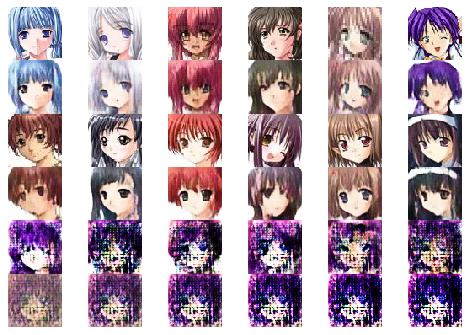

Epoch 62/70
100/100 [==============================] - 26s 255ms/step - r_loss: 0.0871 - a_loss: 0.6944 - e_loss: 0.6891 - d_loss: 0.6932


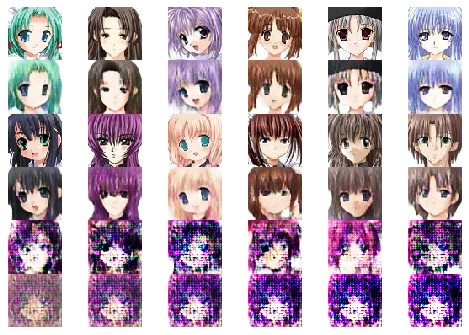

Epoch 63/70
100/100 [==============================] - 26s 257ms/step - r_loss: 0.0867 - a_loss: 0.6941 - e_loss: 0.6884 - d_loss: 0.6932


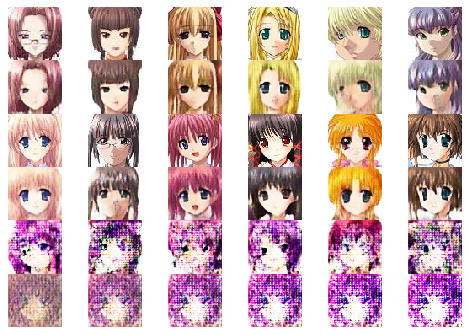

Epoch 64/70
100/100 [==============================] - 26s 260ms/step - r_loss: 0.0865 - a_loss: 0.6940 - e_loss: 0.6869 - d_loss: 0.6934


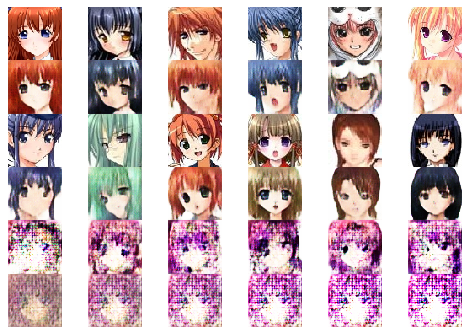

Epoch 65/70
100/100 [==============================] - 26s 259ms/step - r_loss: 0.0862 - a_loss: 0.6940 - e_loss: 0.6865 - d_loss: 0.6934


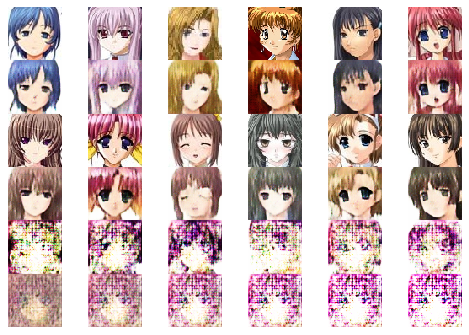

Epoch 66/70
100/100 [==============================] - 26s 259ms/step - r_loss: 0.0861 - a_loss: 0.6942 - e_loss: 0.6865 - d_loss: 0.6934


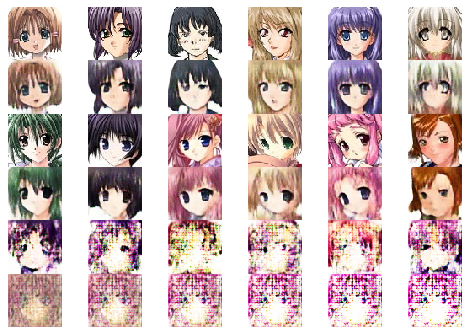

Epoch 67/70
100/100 [==============================] - 26s 260ms/step - r_loss: 0.0859 - a_loss: 0.6941 - e_loss: 0.6867 - d_loss: 0.6934


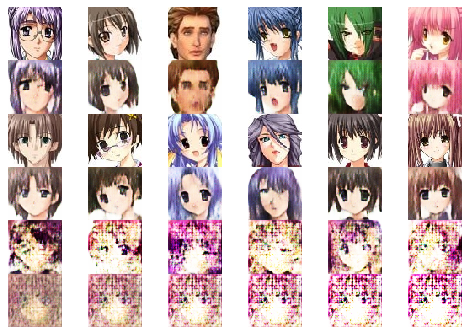

Epoch 68/70
100/100 [==============================] - 26s 258ms/step - r_loss: 0.0859 - a_loss: 0.6942 - e_loss: 0.6869 - d_loss: 0.6934


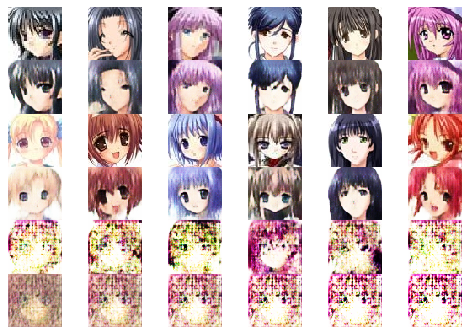

Epoch 69/70
100/100 [==============================] - 26s 258ms/step - r_loss: 0.0857 - a_loss: 0.6942 - e_loss: 0.6871 - d_loss: 0.6934


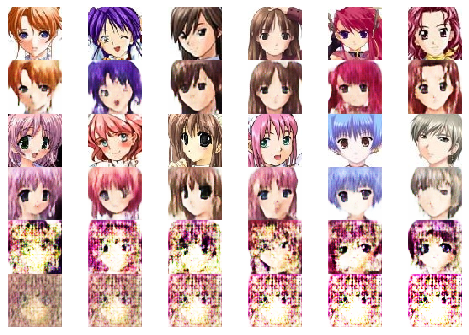

Epoch 70/70
100/100 [==============================] - 26s 260ms/step - r_loss: 0.0856 - a_loss: 0.6942 - e_loss: 0.6873 - d_loss: 0.6934


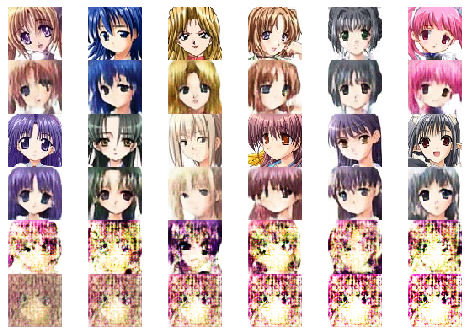

In [123]:
# K.set_value(gan.d_optimizer.learning_rate, 0.000001)
# K.set_value(gan.e_optimizer.learning_rate, 0.000005)
# K.set_value(gan.a_optimizer.learning_rate, 0.0005)
# K.set_value(gan.r_optimizer.learning_rate, 0.0001)

K.set_value(gan.d_optimizer.learning_rate, 0.000001)
K.set_value(gan.e_optimizer.learning_rate, 0.00001)
K.set_value(gan.a_optimizer.learning_rate, 0.00005)

e_count = 10
cb = gan.fit(train,
        epochs=e_count + total_e,        
        initial_epoch = total_e,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=[GANMonitor(now, num_img=6, train_data=train ,test_data=test), keras.callbacks.TensorBoard(log_dir="./logs/"+ now.strftime("%Y%m%d-%H%M%S") + "/")])
total_e += e_count

In [ ]:
count = 4

print(gan.discriminator(train.__getitem__(0)[:count]).numpy())
print(gan.discriminator(gan.autoencoder(train.__getitem__(0)[:count])).numpy())
print(gan.discriminator(gan.generate_img(count)).numpy())
print(gan.discriminator(tf.random.uniform(shape=(count,) + IMG_SISZE + (3,))).numpy())

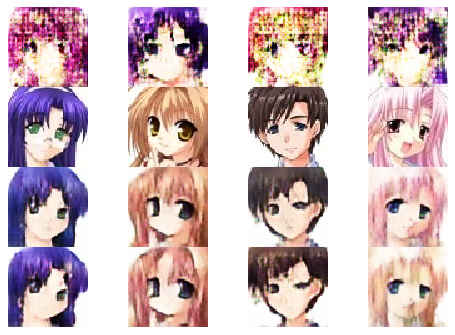

In [124]:
fig = plt.figure()
display_stuff(gan.generate_img(count), fig, 4, 0)
display_stuff(test.__getitem__(0)[:count], fig, 4, 1)
display_stuff(gan.autoencoder(test.__getitem__(0)[:count]), fig, 4, 2)
display_stuff(gan.decoder(gan.encoder(test.__getitem__(0)[:count]) + tf.random.normal(mean=0,stddev=0.1,shape=(count, LATENT_DIM))), fig, 4, 3)